# Broken Telephone Task

## 1.0 Setting up the environment

Install openai library and save the API keys:

In [1]:
%pip install -q openai


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install python-dotenv

  Obtaining dependency information for python-dotenv from https://files.pythonhosted.org/packages/1e/18/98a99ad95133c6a6e2005fe89faedf294a748bd5dc803008059409ac9b1e/python_dotenv-1.1.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from dotenv import load_dotenv

# Load from .env into current file
load_dotenv()

# Save api keys as environment variables
nebius_api_key = os.getenv("nebius_api_key")
os.environ["NEBIUS_API_KEY"] = nebius_api_key

openai_api_key = os.getenv("openai_api_key")
os.environ["OPENAI_API_KEY"] = openai_api_key

## 1.1 Generate an image
Start by generating an image based on a prompt:

In [16]:
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)


response = client.images.generate(
    model="black-forest-labs/flux-dev",
    response_format="b64_json",
    extra_body={
        "response_extension": "png",
        "width": 1024,
        "height": 1024,
        "num_inference_steps": 28,
        "negative_prompt": "",
        "seed": -1
    },
    prompt="An alien with long pink nails and pink dress is programming an app"
)

response_json = response.to_json()

Now, plot the image:

In [8]:
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/0f/70/d61a591958325c357204870b5e7b164f93f2a8cca1dc6ce940f563909a13/matplotlib-3.10.3-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/93/3b/0004767622a9826ea3d95f0e9d98cd8729015768075d61f9fea8eeca42a8/contourpy-1.3.2-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/6a/4e/1c6b35ec7c04d739df4cf5aace4b7ec284d6af2533a65de21972e2f237d9/fonttools-4.58.0-cp312-cp312-macosx_10_13_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 2.2 MB/s eta 0:00:0000:01
  Obtaining dependency in

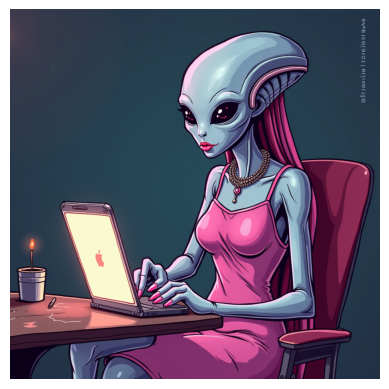

In [17]:
import matplotlib.pyplot as plt
import base64
import json
from PIL import Image
from io import BytesIO


response_data = json.loads(response_json)
b64_image = response_data['data'][0]['b64_json']
image_bytes = base64.b64decode(b64_image)
image = Image.open(BytesIO(image_bytes))
plt.imshow(image)
plt.axis('off')

plt.show()

## 1.2 Create textual description of image
Now, we can create a textual description of the image using a multimodal LLM:

In [19]:
# Define client and model to be used
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "Qwen/Qwen2-VL-72B-Instruct"

# Create image description (requires base64 image)
completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that describes images."},
        {"role": "user", "content": [
            {"type": "text", "text": "Describe this image in one sentence."},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{b64_image}"}
            }
        ]}
    ]
)

print(completion.choices[0].message.content)

An alien-like figure with blue skin and pink hair is sitting at a desk, using a laptop.


## 1.3 Create broken telephone
We can then create our broken telephone using that same functionality:

In [21]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Set paramters
image_creation_model = "black-forest-labs/flux-dev"
description_generator_model = "Qwen/Qwen2-VL-72B-Instruct"
number_of_iterations = 5
start_prompt = "An alien with long pink nails and pink dress is programming an app"

# Create output folder
os.makedirs("telephone_outputs", exist_ok=True)

current_prompt = start_prompt

for step in range(number_of_iterations):
    print(f"\n--- Step {step + 1} ---")
    print(f"Prompt: {current_prompt}")

    # 1. Generate image from prompt
    image_response = client.images.generate(
        model=image_creation_model,
        response_format="b64_json",
        extra_body={
            "response_extension": "png",
            "width": 1024,
            "height": 1024,
            "num_inference_steps": 28,
            "negative_prompt": "",
            "seed": -1
        },
        prompt=current_prompt
    )

    # 2. Decode image
    b64_image = image_response.data[0].b64_json
    image_bytes = base64.b64decode(b64_image)
    image = Image.open(BytesIO(image_bytes))

    # 3. Save image
    image_path = f"telephone_outputs/step_{step+1}.png"
    image.save(image_path)

    # 4. Describe the image
    description_response = client.chat.completions.create(
        model=description_generator_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that describes images."},
            {"role": "user", "content": [
                {"type": "text", "text": "Describe this image in one sentence."},
                {"type": "image_url", "image_url": {
                    "url": f"data:image/png;base64,{b64_image}"}
                }
            ]}
        ]
    )

    description = description_response.choices[0].message.content.strip()
    print(f"Description: {description}")

    # 5. Save description
    with open(f"telephone_outputs/step_{step+1}_description.txt", "w") as f:
        f.write(description)

    # 6. Use the description as the next prompt
    current_prompt = description


--- Step 1 ---
Prompt: An alien with long pink nails and pink dress is programming an app
Description: The image depicts a person with an alien-like appearance using a laptop in a dimly lit room with colorful wall art.

--- Step 2 ---
Prompt: The image depicts a person with an alien-like appearance using a laptop in a dimly lit room with colorful wall art.
Description: An alien is sitting on a bed, using a laptop computer.

--- Step 3 ---
Prompt: An alien is sitting on a bed, using a laptop computer.
Description: A green alien with large eyes and a slender body is sitting on a bed, using a laptop.

--- Step 4 ---
Prompt: A green alien with large eyes and a slender body is sitting on a bed, using a laptop.
Description: A green alien figure is sitting on a bed, working on a laptop.

--- Step 5 ---
Prompt: A green alien figure is sitting on a bed, working on a laptop.
Description: An alien is using a laptop while sitting on a bed.
